# Augmentation

Md. Ahanaf Arif Khan

ID: 1910676110

June 2, 2024


In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 

# https://github.com/tensorflow/tensorflow/issues/53519
os.environ['TF_DEVICE_MIN_SYS_MEMORY_IN_MB'] = '256' 

# Import Necessary Dependencies

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_cv
from keras.layers import Input,Conv2D,MaxPooling2D,Dense,Flatten
from keras import Model

# Hyperparameters

In [17]:
batch_size = 128
epochs = 10
learning_rate = 1e-3

# Creating the dataset

In [18]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(-1 ,28, 28, 1)
x_test = x_test.reshape(-1 ,28, 28, 1)

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

print('Dataset Shapes')
print('Train:', x_train.shape, y_train.shape)
print('Test :', x_test.shape, y_test.shape)

Dataset Shapes
Train: (60000, 28, 28, 1) (60000, 10)
Test : (10000, 28, 28, 1) (10000, 10)


In [19]:
val_split = 0.2
total = x_train.shape[0]

val_samples = int(val_split * total)

x_val = x_train[:val_samples]
y_val = y_train[:val_samples]

x_train = x_train[val_samples:]
y_train = y_train[val_samples:]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(48000, 28, 28, 1) (48000, 10)
(12000, 28, 28, 1) (12000, 10)


In [20]:
def create_tf_dataset(x, y):
    images = tf.data.Dataset.from_tensor_slices(x)
    labels = tf.data.Dataset.from_tensor_slices(y)
    ds = tf.data.Dataset.zip(images, labels)
    ds = ds.batch(batch_size=batch_size)
    return ds

In [21]:
train_ds = create_tf_dataset(x_train, y_train)
val_ds = create_tf_dataset(x_val, y_val)
test_ds = create_tf_dataset(x_test, y_test)

# Defining and Applying Geometric, Photometric, CutMix and MixUp Augmentations 

In [22]:
geometric_augmetation = keras.Sequential([
    keras.layers.RandomRotation(0.1, fill_mode='constant'),
    keras.layers.RandomZoom((-0.2, 0.2), (-0.2, 0.2), fill_mode='constant'),
    keras_cv.layers.RandomShear(0.3, fill_mode='constant')
])

photometric_augmetation = keras.Sequential([
    keras_cv.layers.RandomBrightness(factor=0.4, value_range=(0, 255)),
    keras_cv.layers.RandomContrast(factor=0.4, value_range=(0, 255)),
])


cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_augmetation(images, labels):
    samples = {
        'images': images,
        'labels': labels,
    }
    
    samples = cut_mix(samples, training=True)
    return samples['images'], samples['labels']


def mix_up_augmetation(images, labels):
    samples = {
        'images': images,
        'labels': labels,
    }
    
    samples = mix_up(samples, training=True)
    return samples['images'], samples['labels']


In [23]:
g_train_ds = train_ds.map(lambda x, y: (geometric_augmetation(x), y))
p_train_ds = train_ds.map(lambda x, y: (photometric_augmetation(x), y))
cm_train_ds = train_ds.map(lambda x, y: (cut_mix_augmetation(x, y)))
mu_train_ds = train_ds.map(lambda x, y: (mix_up_augmetation(x, y)))

# Plotting images of samples before and after augmentation

In [24]:
def plot_images(batch, title, top=1):
    for images, labels in batch:
        break
    plt.figure(figsize=(5, 7))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis("off")
        
        if top == 1:
            plt.title(np.argmax(labels[i]))
        else:
            top_args = np.argsort(labels[i])[-2:]
            st = ''
            for x in top_args:
                st += f'{x}: {labels[i][x]*100:0.2f}%\n'
            plt.title(st[:-1])
        plt.suptitle(title)
        
    plt.show()

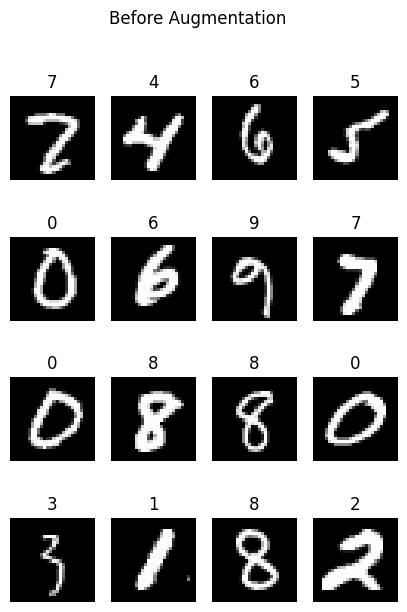

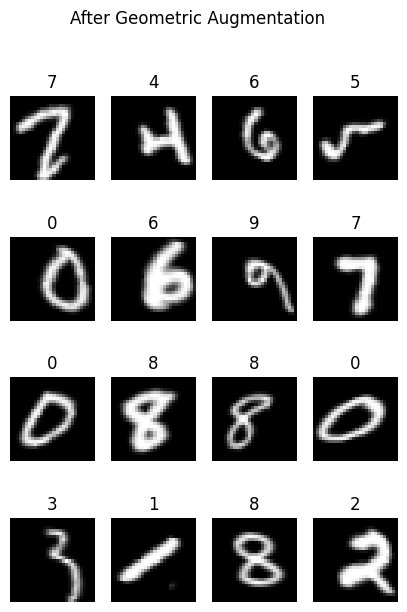

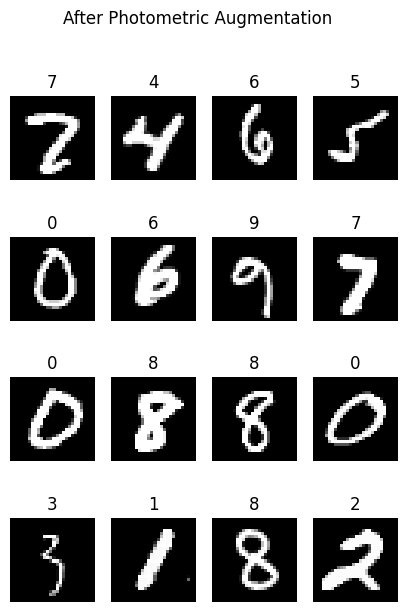

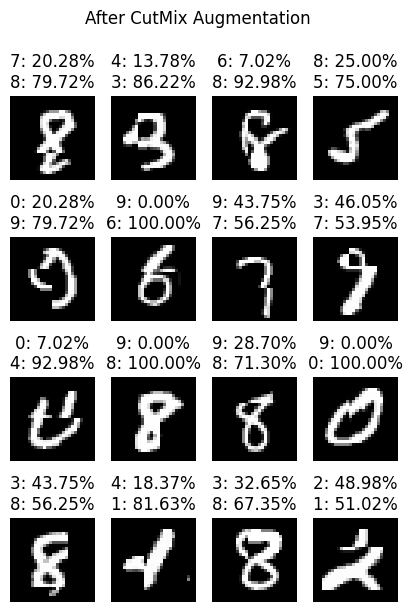

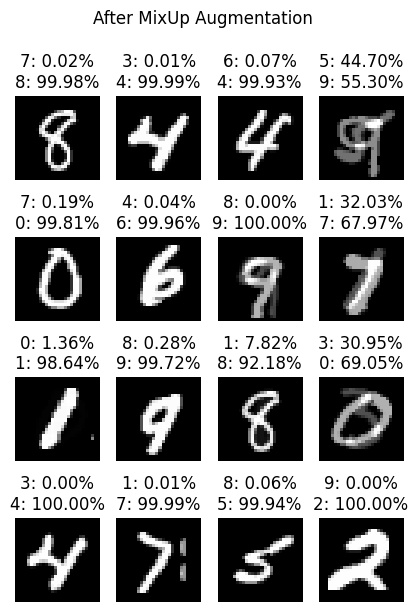

In [25]:
plot_images(train_ds, 'Before Augmentation')
plot_images(g_train_ds, 'After Geometric Augmentation')
plot_images(p_train_ds, 'After Photometric Augmentation')
plot_images(cm_train_ds, 'After CutMix Augmentation', top=2)
plot_images(mu_train_ds, 'After MixUp Augmentation', top=2)

# Define CNN model and evaluation function

In [26]:
def get_compiled_cnn(input_shape=(28, 28, 1), num_classes=10, lr=1e-3):
    inputs = Input(input_shape)
    x = Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(inputs)
    x = MaxPooling2D(pool_size=(3,3), strides = (1,1))(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=(3,3), strides = (1,1))(x)
    x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)
    output = Dense(num_classes, activation = 'softmax')(x)
    model =  Model(inputs, output)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr), 
        loss=keras.losses.CategoricalCrossentropy(), 
        metrics=[
            keras.metrics.CategoricalAccuracy(name='accuracy')
        ]
    )
    return model

In [27]:
def fit_and_evaluate_model(model: keras.Model, train_ds, val_ds, test_ds):
    checkpoint_path = 'checkpoint.keras'
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [
            keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        ],
    )
    
    model.load_weights(checkpoint_path)
    eval = model.evaluate(test_ds, return_dict=True)
    return history.history, eval

# Fit and Evaluate the Model

In [28]:
model = get_compiled_cnn(lr=learning_rate)
hist, eval = fit_and_evaluate_model(model, train_ds, val_ds, test_ds)

Epoch 1/10


I0000 00:00:1717297633.460801  899397 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 4s 7ms/step - loss: 4.1454 - accuracy: 0.8933 - val_loss: 0.1432 - val_accuracy: 0.9626
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0932 - accuracy: 0.9729 - val_loss: 0.1271 - val_accuracy: 0.9662
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0733 - accuracy: 0.9782 - val_loss: 0.0951 - val_accuracy: 0.9761
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0574 - accuracy: 0.9826 - val_loss: 0.1077 - val_accuracy: 0.9758
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0429 - accuracy: 0.9871 - val_loss: 0.1187 - val_accuracy: 0.9762
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.1325 - val_accuracy: 0.9762
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0536 - accuracy: 0.9847 - val_loss: 0.1423 - val_accuracy: 0.9728
Epoch 8/10
375/37

In [29]:
g_model = get_compiled_cnn(lr=learning_rate)
g_hist, g_eval = fit_and_evaluate_model(model, g_train_ds, val_ds, test_ds)

Epoch 1/10
375/375 [==============================] - 6s 15ms/step - loss: 0.3904 - accuracy: 0.8845 - val_loss: 0.2969 - val_accuracy: 0.9415
Epoch 2/10
375/375 [==============================] - 5s 14ms/step - loss: 0.2410 - accuracy: 0.9277 - val_loss: 0.1802 - val_accuracy: 0.9575
Epoch 3/10
375/375 [==============================] - 5s 13ms/step - loss: 0.2030 - accuracy: 0.9388 - val_loss: 0.2397 - val_accuracy: 0.9441
Epoch 4/10
375/375 [==============================] - 4s 11ms/step - loss: 0.1822 - accuracy: 0.9446 - val_loss: 0.1899 - val_accuracy: 0.9560
Epoch 5/10
375/375 [==============================] - 5s 14ms/step - loss: 0.1657 - accuracy: 0.9504 - val_loss: 0.1820 - val_accuracy: 0.9557
Epoch 6/10
375/375 [==============================] - 6s 17ms/step - loss: 0.1563 - accuracy: 0.9532 - val_loss: 0.1385 - val_accuracy: 0.9680
Epoch 7/10
375/375 [==============================] - 6s 17ms/step - loss: 0.1495 - accuracy: 0.9556 - val_loss: 0.1308 - val_accuracy: 0.9664

In [30]:
p_model = get_compiled_cnn(lr=learning_rate)
p_hist, p_eval = fit_and_evaluate_model(model, p_train_ds, val_ds, test_ds)

Epoch 1/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0968 - accuracy: 0.9746 - val_loss: 0.0807 - val_accuracy: 0.9826
Epoch 2/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0517 - accuracy: 0.9854 - val_loss: 0.1631 - val_accuracy: 0.9701
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0416 - accuracy: 0.9878 - val_loss: 0.0984 - val_accuracy: 0.9805
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0386 - accuracy: 0.9887 - val_loss: 0.0984 - val_accuracy: 0.9837
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0336 - accuracy: 0.9895 - val_loss: 0.1185 - val_accuracy: 0.9812
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0319 - accuracy: 0.9907 - val_loss: 0.0983 - val_accuracy: 0.9846
Epoch 7/10
375/375 [==============================] - 3s 7ms/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.0963 - val_accuracy: 0.9843
Epoch 

In [31]:
cm_model = get_compiled_cnn(lr=learning_rate)
cm_hist, cm_eval = fit_and_evaluate_model(model, cm_train_ds, val_ds, test_ds)

Epoch 1/10
375/375 [==============================] - 2s 5ms/step - loss: 1.4261 - accuracy: 0.6319 - val_loss: 0.3526 - val_accuracy: 0.9452
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2503 - accuracy: 0.6886 - val_loss: 0.2729 - val_accuracy: 0.9607
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2104 - accuracy: 0.6970 - val_loss: 0.2899 - val_accuracy: 0.9605
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 1.1906 - accuracy: 0.7003 - val_loss: 0.2431 - val_accuracy: 0.9623
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 1.1729 - accuracy: 0.7064 - val_loss: 0.2663 - val_accuracy: 0.9634
Epoch 6/10
375/375 [==============================] - 3s 7ms/step - loss: 1.1619 - accuracy: 0.7034 - val_loss: 0.2692 - val_accuracy: 0.9643
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 1.1508 - accuracy: 0.7064 - val_loss: 0.2737 - val_accuracy: 0.9666
Epoch 

In [32]:
mu_model = get_compiled_cnn(lr=learning_rate)
mu_hist, mu_eval = fit_and_evaluate_model(model, mu_train_ds, val_ds, test_ds)

Epoch 1/10
375/375 [==============================] - 3s 7ms/step - loss: 0.4234 - accuracy: 0.9384 - val_loss: 0.0883 - val_accuracy: 0.9774
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.3917 - accuracy: 0.9433 - val_loss: 0.0730 - val_accuracy: 0.9822
Epoch 3/10
375/375 [==============================] - 3s 8ms/step - loss: 0.3802 - accuracy: 0.9433 - val_loss: 0.0654 - val_accuracy: 0.9834
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3679 - accuracy: 0.9441 - val_loss: 0.0710 - val_accuracy: 0.9818
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3609 - accuracy: 0.9445 - val_loss: 0.0680 - val_accuracy: 0.9822
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3565 - accuracy: 0.9459 - val_loss: 0.0711 - val_accuracy: 0.9808
Epoch 7/10
375/375 [==============================] - 3s 7ms/step - loss: 0.3495 - accuracy: 0.9475 - val_loss: 0.0582 - val_accuracy: 0.9835
Epoch 

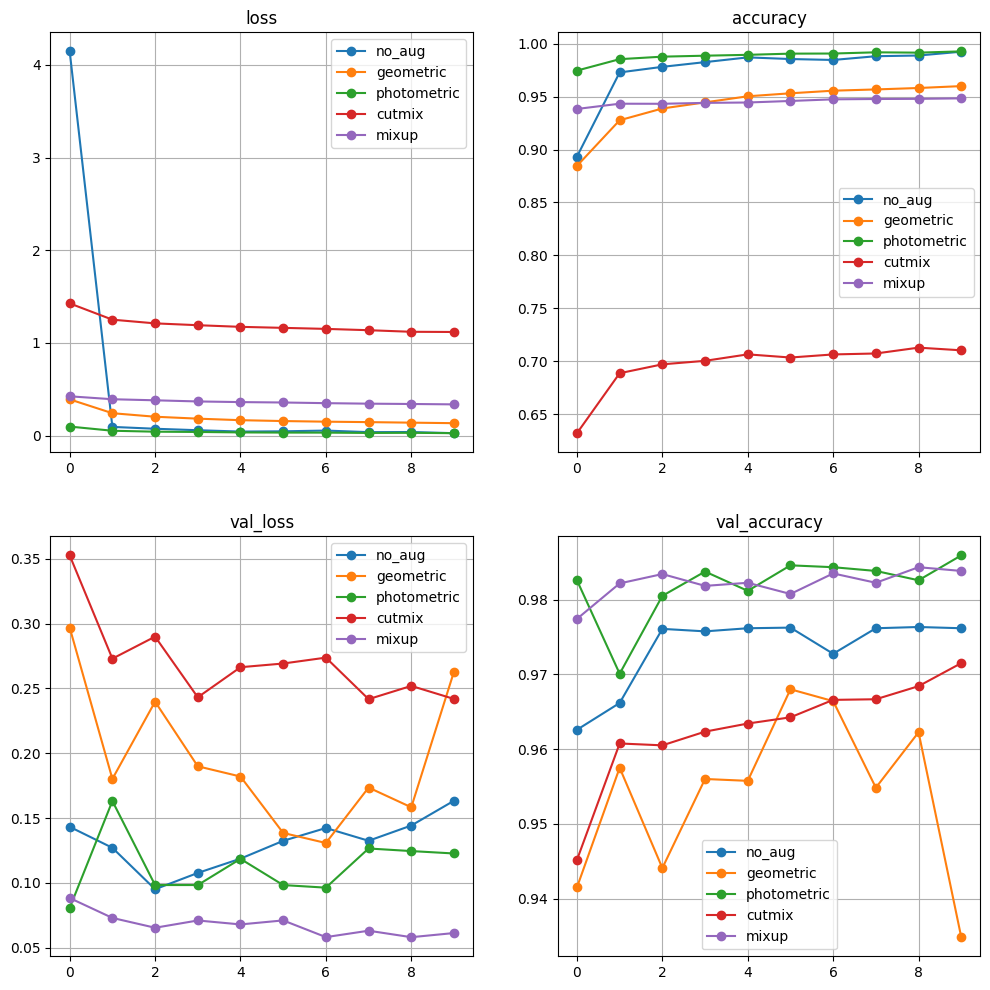

In [36]:
keys = list(hist.keys())
i = 1
plt.figure(figsize=(12, 12))
for key in keys:
    plt.subplot(2,2,i)
    i += 1
    for tr in [hist, g_hist, p_hist, cm_hist, mu_hist]:
        plt.plot(tr[key], marker='o', linestyle='-')
        plt.grid('on')
        plt.legend(['no_aug', 'geometric', 'photometric', 'cutmix', 'mixup'])
        plt.title(key)
        


In [37]:
print('Test results:')
print(f'No Augmentation         : {eval["accuracy"]*100:0.2f}%')
print(f'Geometric Augmentation  : {g_eval["accuracy"]*100:0.2f}%')
print(f'Photometric Augmentation: {p_eval["accuracy"]*100:0.2f}%')
print(f'CutMix Augmentation     : {cm_eval["accuracy"]*100:0.2f}%')
print(f'MixUp Augmentation      : {mu_eval["accuracy"]*100:0.2f}%')

Test results:
No Augmentation         : 97.73%
Geometric Augmentation  : 96.78%
Photometric Augmentation: 98.32%
CutMix Augmentation     : 97.12%
MixUp Augmentation      : 98.51%
